# Grism Output Campatibility

This notebook demonstrates the compatibility of various grism code outputs with the current astropy/specutils framework. It covers mainly the cases of
- JWST MOS
- PyLINEAR
- Grizli
- aXe

In [19]:
from astropy.utils.data import download_file
from astropy.table import Table
from astropy.io import fits
from specutils import Spectrum1D, SpectrumCollection, SpectrumList
import matplotlib.pyplot as plt
import re
import numpy as np
from astropy.wcs import WCS
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below 

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x121e2b3a0>

In [20]:
plt.rcParams["figure.figsize"] = [16, 9]

In [21]:
# %matplotlib inline

## JWST

Data provided by the latest pipeline outputs for NIRSpec.

In [22]:
fn = download_file('https://stsci.box.com/shared/static/1rryl86jfgh5l0wu9sfyjzrw87hcg8n0.fits', cache=True)

In [23]:
with fits.open(fn) as hdulist:
    prime_hdu = hdulist['PRIMARY'].header
    title = f"{prime_hdu['INSTRUME']} {prime_hdu['DETECTOR']} {prime_hdu['FILTER']} {prime_hdu['GRATING']}"

In [24]:
spec = Spectrum1D.read(fn, format='JWST x1d')

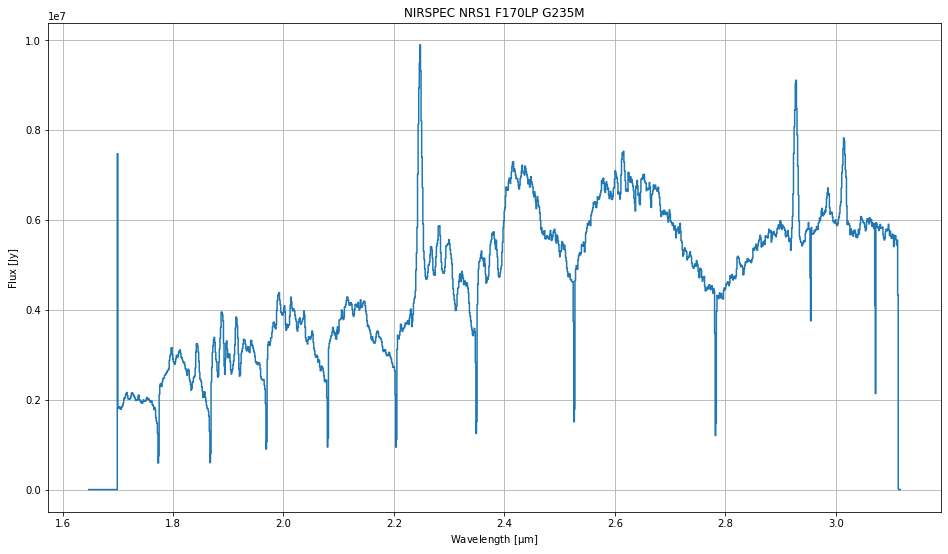

In [25]:
f, ax = plt.subplots()

ax.grid()

ax.set_title(title)
ax.step(spec.spectral_axis, spec.flux, where='mid')
ax.errorbar(spec.spectral_axis, spec.flux, yerr=spec.uncertainty.quantity, linestyle='')
ax.set_xlabel(f"Wavelength [{ax.xaxis.get_label().get_text()}]")
ax.set_ylabel(f"Flux [{ax.yaxis.get_label().get_text()}]")

f.savefig("jwst_compat.png")

## Grizli

Generated data from a reduction over observation 

In [26]:
fn = download_file('https://stsci.box.com/shared/static/z8l95abqfbl1odaa5kwqww5x77k4hsa9.fits', cache=True)

In [27]:
with fits.open(fn) as hdulist:
    spec_g141 = Spectrum1D(
        spectral_axis=hdulist[1].data['wave'] * u.Unit('Angstrom'),
        flux=hdulist[1].data['flux'] * u.Unit('count/s'),
        uncertainty=StdDevUncertainty(hdulist[1].data['err'] * u.Unit('count/s')),
        wcs=WCS(hdulist[1].header))
    
    spec_g102 = Spectrum1D(
        spectral_axis=hdulist[2].data['wave'] * u.Unit('Angstrom'),
        flux=hdulist[2].data['flux'] * u.Unit('count/s'),
        uncertainty=StdDevUncertainty(hdulist[2].data['err'] * u.Unit('count/s')),
        wcs=WCS(hdulist[2].header))

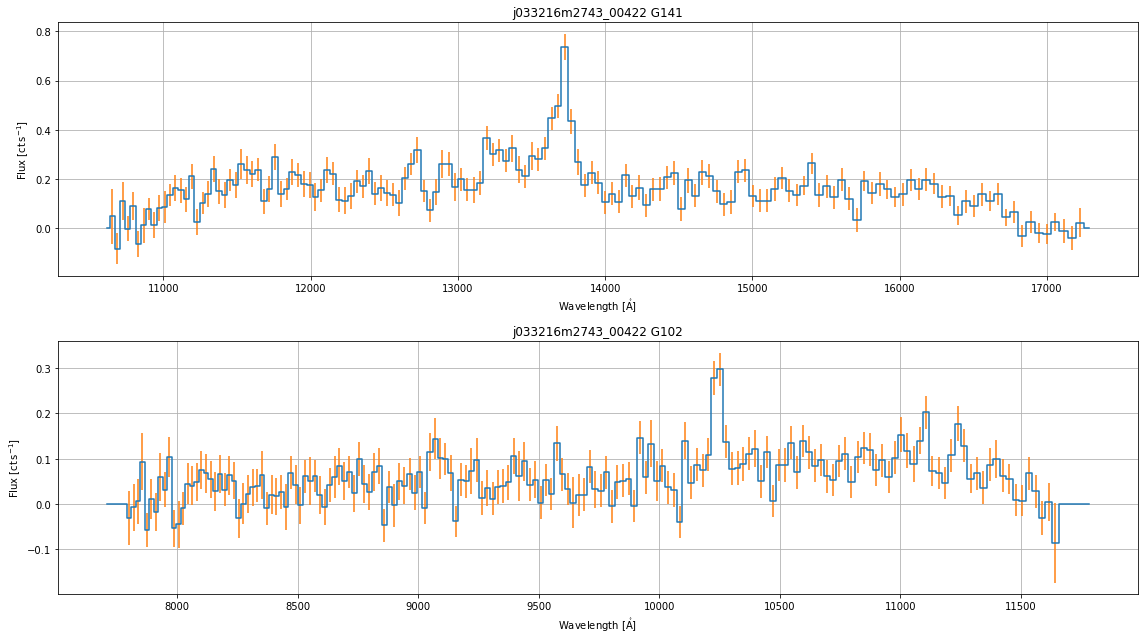

In [28]:
f, (ax1, ax2) = plt.subplots(2, 1)

ax1.grid()
ax1.step(spec_g141.spectral_axis, spec_g141.flux, where='mid')
ax1.errorbar(spec_g141.spectral_axis, spec_g141.flux, yerr=spec_g141.uncertainty.quantity, linestyle='')
ax1.set_title("j033216m2743_00422 G141")
ax1.set_xlabel(f"Wavelength [{ax1.xaxis.get_label().get_text()}]")
ax1.set_ylabel(f"Flux [{ax1.yaxis.get_label().get_text()}]")

ax2.grid()
ax2.step(spec_g102.spectral_axis, spec_g102.flux, where='mid')
ax2.errorbar(spec_g102.spectral_axis, spec_g102.flux, yerr=spec_g102.uncertainty.quantity, linestyle='')
ax2.set_title("j033216m2743_00422 G102")
ax2.set_xlabel(f"Wavelength [{ax2.xaxis.get_label().get_text()}]")
ax2.set_ylabel(f"Flux [{ax2.yaxis.get_label().get_text()}]")

f.tight_layout()
f.savefig("grizli_g.png")

In [29]:
## PyLINEAR

In [30]:
# fn = download_file('https://stsci.box.com/shared/static/c7fgcv6rxg77mum64gmikcjn0q9nur79.fits', cache=True)

In [31]:
# hdulist = fits.open(fn)

In [32]:
# hdulist[2].data.shape

In [33]:
# f, ax = plt.subplots()

# ax.imshow(hdulist[1].data)

## aXe

Due to the nature of grism analysis, the beams generated are not the same shape. This is true across both the different objects, as well as the different orders. As such, we cannot use a `SpectrumCollection`, which requires that the data all be the same shape. Instead, we opt for a simple `SpectrumList` to contain our individual `Spectrum1D` objects. In general, we only care about the `A` order of the generated beams, so our `SpectrumList` will contain a `Spectrum1D` for each individual object, containing the spectral data for order 'A'.

### One dimensional spectra without using optimal extraction

In [34]:
fn = download_file("https://stsci.box.com/shared/static/tr7f7iip75670um01y1qco520dygk5tm.fits", cache=True)

In [35]:
with fits.open(fn) as hdulist:
    # Get the number of unique objects in the data product
    # n_obj = np.max([int(next(iter(re.findall(r'\d+', hdulist[i].name)),0)) for i in range(len(hdulist))])
    
    # Grab the first six, since that's all we end up plotting
    n_obj = 6

    # Store the main wcs information to append to the `Spectrum1D` object
    wcs = WCS(hdulist[0].header)

    # Instantiate our spectrum list container
    spec_list = SpectrumList()

    for i in range(1, n_obj+1):
        beam_id = f'BEAM_{i}A'

        if beam_id not in hdulist:
            continue

        spec = Spectrum1D(
            spectral_axis=hdulist[beam_id].data['LAMBDA'] * u.Unit("Angstrom"),
            flux=hdulist[beam_id].data['FLUX'] * u.Unit('erg cm−2 s−1 AA−1'),
            wcs=wcs,
            uncertainty=StdDevUncertainty(hdulist[beam_id].data['FERROR'] * u.Unit('erg cm−2 s−1 AA−1')),
            meta={'beam_id': beam_id}
        )

        spec_list.append(spec)

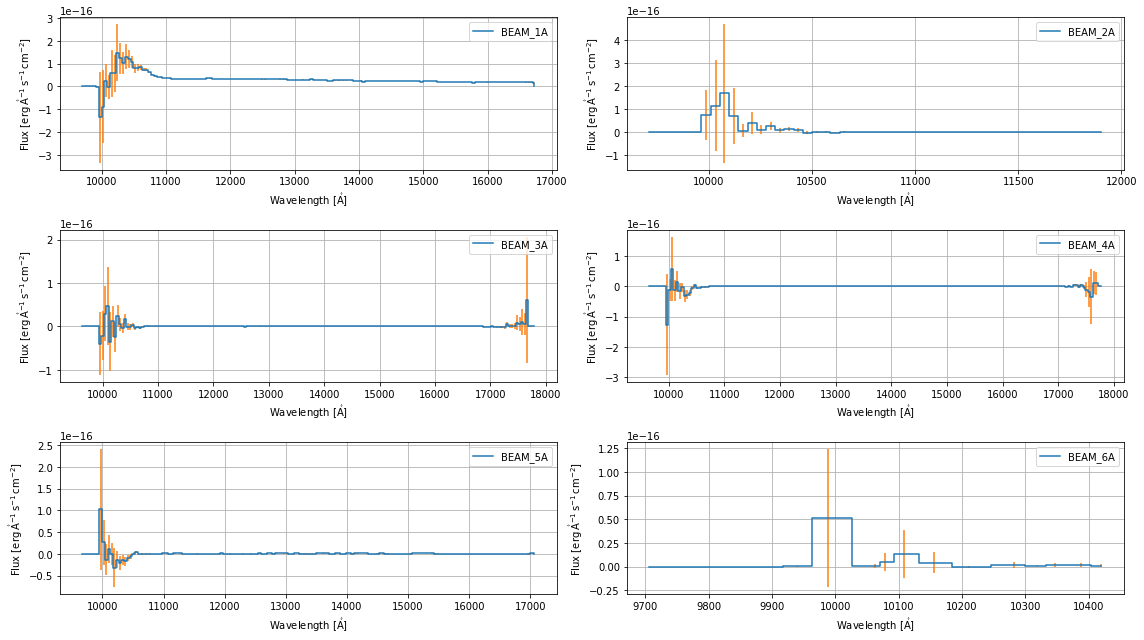

In [36]:
index = 100

f, axes = plt.subplots(3, 2)

for row in range(3):
    for col in range(2):
        ax = axes[row,col]
        spec = spec_list[2 * row + col]
        
        ax.grid()
        ax.step(spec.spectral_axis, spec.flux, where='mid', label=f"{spec.meta['beam_id']}")
        ax.errorbar(spec.spectral_axis, spec.flux, yerr=spec.uncertainty.quantity, linestyle='')
        ax.set_xlabel(f"Wavelength [{ax.xaxis.get_label().get_text()}]")
        ax.set_ylabel(f"Flux [{ax.yaxis.get_label().get_text()}]")
        ax.legend(loc=0)

f.tight_layout()

f.savefig("axe_compat_wout_opt_ext.png")

### One dimensional spectra using optimal extraction

In [37]:
fn = download_file("https://stsci.box.com/shared/static/2ks8o8q57kw0htlvsqzwbuw8no0qv9vs.fits", cache=True)

In [38]:
with fits.open(fn) as hdulist:
    # Get the number of unique objects in the data product
    # n_obj = np.max([int(next(iter(re.findall(r'\d+', hdulist[i].name)),0)) for i in range(len(hdulist))])
    
    # Grab the first six, since that's all we end up plotting
    n_obj = 6

    # Store the main wcs information to append to the `Spectrum1D` object
    wcs = WCS(hdulist[0].header)

    # Instantiate our spectrum list container
    spec_list = SpectrumList()

    for i in range(1, n_obj+1):
        beam_id = f'BEAM_{i}A'

        if beam_id not in hdulist:
            continue

        spec = Spectrum1D(
            spectral_axis=hdulist[beam_id].data['LAMBDA'] * u.Unit("Angstrom"),
            flux=hdulist[beam_id].data['FLUX'] * u.Unit('erg cm−2 s−1 AA−1'),
            wcs=wcs,
            uncertainty=StdDevUncertainty(hdulist[beam_id].data['FERROR'] * u.Unit('erg cm−2 s−1 AA−1')),
            meta={'beam_id': beam_id}
        )

        spec_list.append(spec)

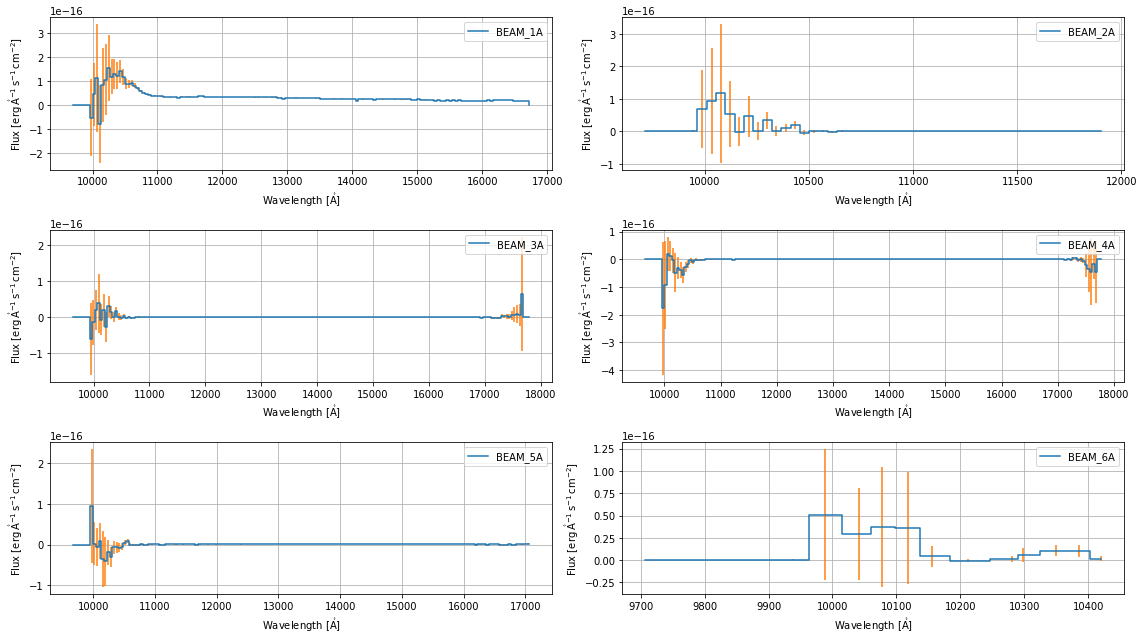

In [39]:
index = 100

f, axes = plt.subplots(3, 2)

for row in range(3):
    for col in range(2):
        ax = axes[row,col]
        spec = spec_list[2 * row + col]
        
        ax.grid()
        ax.step(spec.spectral_axis, spec.flux, where='mid', label=f"{spec.meta['beam_id']}")
        ax.errorbar(spec.spectral_axis, spec.flux, yerr=spec.uncertainty.quantity, linestyle='')
        ax.set_xlabel(f"Wavelength [{ax.xaxis.get_label().get_text()}]")
        ax.set_ylabel(f"Flux [{ax.yaxis.get_label().get_text()}]")
        ax.legend(loc=0)

f.tight_layout()
f.savefig("axe_compat_w_opt_ext.png")